In [521]:
import argparse
import time
import numpy as np
from math import ceil
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn.functional as F
from torch import optim

# from model import RW_NN
from utils import load_data, generate_batches, accuracy, AverageMeter

In [522]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.nn.parameter import Parameter

class RW_NN(nn.Module):
    # new hyperparameters
    # max_num_children
    def __init__(self, input_dim, max_step, hidden_graphs, size_hidden_graphs, hidden_dim, penultimate_dim, normalize, n_classes, dropout, device):
        super(RW_NN, self).__init__()
        self.max_step = max_step
        self.hidden_graphs = hidden_graphs
        self.size_hidden_graphs = size_hidden_graphs
        self.normalize = normalize
        self.device = device
        self.adj_hidden = Parameter(torch.FloatTensor(hidden_graphs, (size_hidden_graphs*(size_hidden_graphs-1))//2))
        self.features_hidden = Parameter(torch.FloatTensor(hidden_graphs, size_hidden_graphs, hidden_dim))
        self.fc = torch.nn.Linear(input_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_graphs*max_step)
        self.fc1 = torch.nn.Linear(hidden_graphs*max_step, penultimate_dim)
        self.fc2 = torch.nn.Linear(penultimate_dim, n_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.init_weights()

    def init_weights(self):
        self.adj_hidden.data.uniform_(-1, 1)
        self.features_hidden.data.uniform_(0, 1)

        
    def forward(self, adj, features, graph_indicator):
        unique, counts = torch.unique(graph_indicator, return_counts=True)
        n_graphs = unique.size(0)
        n_nodes = features.size(0)

        if self.normalize:
            norm = counts.unsqueeze(1).repeat(1, self.hidden_graphs)
        
        adj_hidden_norm = torch.zeros(self.hidden_graphs, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
        idx = torch.triu_indices(self.size_hidden_graphs, self.size_hidden_graphs, 1)
        adj_hidden_norm[:,idx[0],idx[1]] = self.relu(self.adj_hidden)
        adj_hidden_norm = adj_hidden_norm + torch.transpose(adj_hidden_norm, 1, 2)
        x = self.sigmoid(self.fc(features))
        z = self.features_hidden
        zx = torch.einsum("abc,dc->abd", (z, x))
        
        out = list()
        for i in range(self.max_step):
            if i == 0:
                eye = torch.eye(self.size_hidden_graphs, device=self.device)
                eye = eye.repeat(self.hidden_graphs, 1, 1)              
                o = torch.einsum("abc,acd->abd", (eye, z))
                t = torch.einsum("abc,dc->abd", (o, x))
            else:
                x = torch.spmm(adj, x)
                z = torch.einsum("abc,acd->abd", (adj_hidden_norm, z))
                t = torch.einsum("abc,dc->abd", (z, x))
            t = self.dropout(t)
            t = torch.mul(zx, t)
            t = torch.zeros(t.size(0), t.size(1), n_graphs, device=self.device).index_add_(2, graph_indicator, t)
            t = torch.sum(t, dim=1)
            t = torch.transpose(t, 0, 1)
            if self.normalize:
                t /= norm
            out.append(t)
            
        out = torch.cat(out, dim=1)
        out = self.bn(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return F.log_softmax(out, dim=1)
    def get_hidden_graphs_adjacency_list(self):
        """Converts the upper-triangular adjacency data to adjacency lists."""
        adj_hidden_norm = torch.zeros(self.hidden_graphs, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
        idx = torch.triu_indices(self.size_hidden_graphs, self.size_hidden_graphs, 1)
        adj_hidden_norm[:, idx[0], idx[1]] = self.relu(self.adj_hidden)
        adj_hidden_norm = adj_hidden_norm + torch.transpose(adj_hidden_norm, 1, 2)
        
        # Convert each hidden graph's adjacency matrix to an adjacency list
        adjacency_lists = []
        for i in range(self.hidden_graphs):
            adj_list = {}
            adj_matrix = adj_hidden_norm[i].detach().cpu().numpy()  # Move to CPU for easy processing
            for row in range(adj_matrix.shape[0]):
                adj_list[row] = list(np.where(adj_matrix[row] > 0)[0])  # Find connected nodes
            adjacency_lists.append(adj_list)
        
        return adjacency_lists
        

In [523]:
# settings
from types import SimpleNamespace
args = SimpleNamespace(
    dataset='synthetic',
    use_node_labels=False,
    lr=1e-2,
    dropout=0.2,
    batch_size=8,
    epochs=10,
    hidden_graphs=8,
    size_hidden_graphs=6,
    hidden_dim=4,
    penultimate_dim=32,
    max_step=2,
    normalize=False,
)

In [524]:
import matplotlib.pyplot as plt
import networkx as nx
import random

open("graph_A.txt", "w").close()

open("graph_indicator.txt", "w").close()
open("graph_labels.txt", "w").close()
graph_indicator = 1
random_num = random.randint(5, 30)
random_graphs = []
for _ in range(25):
    n = random_num  # 10 nodes
    m = random_num  # 20 edges
    # seed = 42  # seed random number generators for reproducibility

    # Use seed for reproducibility
    G = nx.gnm_random_graph(n, m)
    random_graphs.append(G)
    # some properties
    # print("node degree clustering")
    # for v in nx.nodes(G):
    #     print(f"{v} {nx.degree(G, v)} {nx.clustering(G, v)}")

    # print()
    print(nx.generate_adjlist(G))
    pairs = []

    for line in nx.generate_adjlist(G):
        # Split the line into nodes
        nodes = line.split()
        # The first node is the source, and the rest are targets
        source = nodes[0]
        targets = nodes[1:]
        
        # Generate (source, target) pairs
        for target in targets:
            print(str(int(source) + 1))
            pairs.append((str(int(source) + 1), str(int(target) + 1)))
    print(pairs)
    # Write the result to a file
    with open("graph_A.txt", "a") as f:
        for pair in pairs:
            f.write(f"{pair[0]}, {pair[1]}\n")

    with open("graph_indicator.txt", "a") as f:
        for pair in pairs:
            f.write(f"{graph_indicator}\n")
    with open("graph_labels.txt", "a") as f:
        f.write(f"0\n")
        graph_indicator += 1

<generator object generate_adjlist at 0x7fc408303200>
1
1
1
2
2
4
5
6
7
7
7
7
7
9
9
12
12
15
[('1', '8'), ('1', '18'), ('1', '5'), ('2', '6'), ('2', '4'), ('4', '16'), ('5', '18'), ('6', '17'), ('7', '15'), ('7', '14'), ('7', '11'), ('7', '10'), ('7', '9'), ('9', '13'), ('9', '10'), ('12', '14'), ('12', '18'), ('15', '16')]
<generator object generate_adjlist at 0x7fc42a007ba0>
2
2
2
2
3
3
3
4
4
5
5
5
6
9
10
11
13
15
[('2', '6'), ('2', '7'), ('2', '4'), ('2', '13'), ('3', '15'), ('3', '6'), ('3', '14'), ('4', '18'), ('4', '11'), ('5', '13'), ('5', '11'), ('5', '10'), ('6', '17'), ('9', '18'), ('10', '14'), ('11', '12'), ('13', '16'), ('15', '17')]
<generator object generate_adjlist at 0x7fc42a007ba0>
1
2
2
2
2
3
3
3
4
4
6
6
6
6
10
10
11
11
[('1', '7'), ('2', '7'), ('2', '11'), ('2', '17'), ('2', '14'), ('3', '6'), ('3', '10'), ('3', '15'), ('4', '11'), ('4', '17'), ('6', '8'), ('6', '18'), ('6', '13'), ('6', '12'), ('10', '12'), ('10', '18'), ('11', '13'), ('11', '18')]
<generator objec

In [525]:
import matplotlib.pyplot as plt
import networkx as nx
import random
   
random_num = random.randint(5, 30)
random_graphs = []
for _ in range(25):
    n = random_num  # 10 nodes
    m = random_num  # 20 edges
    # seed = 42  # seed random number generators for reproducibility

    # Use seed for reproducibility
    G = nx.cycle_graph(n)
    random_graphs.append(G)
    # some properties
    # print("node degree clustering")
    # for v in nx.nodes(G):
    #     print(f"{v} {nx.degree(G, v)} {nx.clustering(G, v)}")

    # print()
    pairs = []

    for line in nx.generate_adjlist(G):
        # Split the line into nodes
        nodes = line.split()
        # The first node is the source, and the rest are targets
        source = nodes[0]
        targets = nodes[1:]
        
        # Generate (source, target) pairs
        for target in targets:
            pairs.append((str(int(source) + 1), str(int(target) + 1)))
        
    # Write the result to a file
    with open("graph_A.txt", "a") as f:
        for pair in pairs:
            f.write(f"{pair[0]}, {pair[1]}\n")
    with open("graph_indicator.txt", "a") as f:
        for pair in pairs:
            f.write(f"{graph_indicator}\n")
    with open("graph_labels.txt", "a") as f:
        f.write(f"1\n")
        graph_indicator += 1

In [526]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [527]:
adj_lst, features_lst, class_labels = load_data(args.dataset, args.use_node_labels)

N = len(adj_lst)
features_dim = features_lst[0].shape[1]

enc = LabelEncoder()
class_labels = enc.fit_transform(class_labels)
n_classes = np.unique(class_labels).size
y = [np.array(class_labels[i]) for i in range(class_labels.size)]

kf = KFold(n_splits=10, shuffle=True, random_state=13)
it = 0
accs = list()

In [528]:
model = []

for train_index, test_index in kf.split(y):
    it += 1
    
    idx = np.random.permutation(train_index)
    train_index = idx[:int(idx.size*0.9)].tolist()
    val_index = idx[int(idx.size*0.9):].tolist()

    n_train = len(train_index)
    n_val = len(val_index)
    n_test = len(test_index)

    adj_train = [adj_lst[i] for i in train_index]
    features_train = [features_lst[i] for i in train_index]
    y_train = [y[i] for i in train_index]

    adj_val = [adj_lst[i] for i in val_index]
    features_val = [features_lst[i] for i in val_index]
    y_val = [y[i] for i in val_index]

    adj_test = [adj_lst[i] for i in test_index]
    features_test = [features_lst[i] for i in test_index]
    y_test = [y[i] for i in test_index]

    adj_train, features_train, graph_indicator_train, y_train = generate_batches(adj_train, features_train, y_train, args.batch_size, device)
    adj_val, features_val, graph_indicator_val, y_val = generate_batches(adj_val, features_val, y_val, args.batch_size, device)
    adj_test, features_test, graph_indicator_test, y_test = generate_batches(adj_test, features_test, y_test, args.batch_size, device)

    n_train_batches = ceil(n_train/args.batch_size)
    n_val_batches = ceil(n_val/args.batch_size)
    n_test_batches = ceil(n_test/args.batch_size)
    
    model = RW_NN(features_dim, args.max_step, args.hidden_graphs, args.size_hidden_graphs, args.hidden_dim, args.penultimate_dim, args.normalize, n_classes, args.dropout, device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    def train(epoch, adj, features, graph_indicator, y):
        optimizer.zero_grad()
        output = model(adj, features, graph_indicator)
        loss_train = F.cross_entropy(output, y)
        loss_train.backward()
        optimizer.step()
        return output, loss_train

    def test(adj, features, graph_indicator, y):
        output = model(adj, features, graph_indicator)
        loss_test = F.cross_entropy(output, y)
        return output, loss_test

    best_acc = 0

    for epoch in range(args.epochs):
        start = time.time()
        model.train()
        train_loss = AverageMeter()
        train_acc = AverageMeter()

        # Train for one epoch
        for i in range(n_train_batches):
            output, loss = train(epoch, adj_train[i], features_train[i], graph_indicator_train[i], y_train[i])
            train_loss.update(loss.item(), output.size(0))
            train_acc.update(accuracy(output.data, y_train[i].data), output.size(0))

        # Evaluate on validation set
        model.eval()
        val_loss = AverageMeter()
        val_acc = AverageMeter()

        for i in range(n_val_batches):
            output, loss = test(adj_val[i], features_val[i], graph_indicator_val[i], y_val[i])
            val_loss.update(loss.item(), output.size(0))
            val_acc.update(accuracy(output.data, y_val[i].data), output.size(0))

        scheduler.step()
        
        # Print results
        print("Cross-val iter:", '%02d' % it, "epoch:", '%03d' % (epoch + 1), "train_loss=", "{:.5f}".format(train_loss.avg),
            "train_acc=", "{:.5f}".format(train_acc.avg), "val_loss=", "{:.5f}".format(val_loss.avg),
            "val_acc=", "{:.5f}".format(val_acc.avg), "time=", "{:.5f}".format(time.time() - start))
        
        # Remember best accuracy and save checkpoint
        is_best = val_acc.avg >= best_acc
        best_acc = max(val_acc.avg, best_acc)
        if is_best:
            early_stopping_counter = 0
            torch.save({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            }, 'model_best.pth.tar')

    print("Optimization finished!")

    # Testing
    test_loss = AverageMeter()
    test_acc = AverageMeter()
    print("Loading checkpoint!")
    checkpoint = torch.load('model_best.pth.tar')
    epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    for i in range(n_test_batches):
        output, loss = test(adj_test[i], features_test[i], graph_indicator_test[i], y_test[i])
        test_loss.update(loss.item(), output.size(0))
        test_acc.update(accuracy(output.data, y_test[i].data), output.size(0))
    accs.append(test_acc.avg.cpu().numpy())

    # Print results
    print("test_loss=", "{:.5f}".format(test_loss.avg), "test_acc=", "{:.5f}".format(test_acc.avg))
    print()
    
print("avg_test_acc=", "{:.5f}".format(np.mean(accs)))

Cross-val iter: 01 epoch: 001 train_loss= 0.68571 train_acc= 0.50000 val_loss= 2.35925 val_acc= 0.00000 time= 0.02501
Cross-val iter: 01 epoch: 002 train_loss= 0.59428 train_acc= 0.72500 val_loss= 2.07621 val_acc= 0.00000 time= 0.03537
Cross-val iter: 01 epoch: 003 train_loss= 0.56653 train_acc= 0.72500 val_loss= 0.77812 val_acc= 0.60000 time= 0.02247
Cross-val iter: 01 epoch: 004 train_loss= 0.49531 train_acc= 0.80000 val_loss= 0.43680 val_acc= 0.80000 time= 0.01608
Cross-val iter: 01 epoch: 005 train_loss= 0.47296 train_acc= 0.80000 val_loss= 0.37783 val_acc= 0.80000 time= 0.01454
Cross-val iter: 01 epoch: 006 train_loss= 0.47855 train_acc= 0.82500 val_loss= 0.39032 val_acc= 0.80000 time= 0.01434
Cross-val iter: 01 epoch: 007 train_loss= 0.44000 train_acc= 0.80000 val_loss= 0.42160 val_acc= 0.80000 time= 0.01506
Cross-val iter: 01 epoch: 008 train_loss= 0.34358 train_acc= 0.87500 val_loss= 0.39076 val_acc= 0.80000 time= 0.01495
Cross-val iter: 01 epoch: 009 train_loss= 0.48924 train_

In [529]:
adjacency_lists = model.get_hidden_graphs_adjacency_list()

# Print the adjacency lists for each hidden graph
for i, adj_list in enumerate(adjacency_lists):
    print(f"Hidden Graph {i}:")
    for node, neighbors in adj_list.items():
        print(f"  Node {node}: {neighbors}")

Hidden Graph 0:
  Node 0: [5]
  Node 1: [2, 5]
  Node 2: [1]
  Node 3: [4, 5]
  Node 4: [3]
  Node 5: [0, 1, 3]
Hidden Graph 1:
  Node 0: []
  Node 1: [4, 5]
  Node 2: []
  Node 3: [4, 5]
  Node 4: [1, 3]
  Node 5: [1, 3]
Hidden Graph 2:
  Node 0: [3]
  Node 1: [3, 4, 5]
  Node 2: []
  Node 3: [0, 1, 5]
  Node 4: [1]
  Node 5: [1, 3]
Hidden Graph 3:
  Node 0: [1, 2, 3, 4, 5]
  Node 1: [0, 2, 3, 4, 5]
  Node 2: [0, 1, 5]
  Node 3: [0, 1, 4, 5]
  Node 4: [0, 1, 3]
  Node 5: [0, 1, 2, 3]
Hidden Graph 4:
  Node 0: [1, 2, 3, 4]
  Node 1: [0, 4]
  Node 2: [0, 4, 5]
  Node 3: [0, 4, 5]
  Node 4: [0, 1, 2, 3]
  Node 5: [2, 3]
Hidden Graph 5:
  Node 0: [2]
  Node 1: [4]
  Node 2: [0, 4]
  Node 3: [5]
  Node 4: [1, 2, 5]
  Node 5: [3, 4]
Hidden Graph 6:
  Node 0: [4]
  Node 1: [3, 5]
  Node 2: [3, 4]
  Node 3: [1, 2]
  Node 4: [0, 2, 5]
  Node 5: [1, 4]
Hidden Graph 7:
  Node 0: [5]
  Node 1: []
  Node 2: [4]
  Node 3: [4]
  Node 4: [2, 3, 5]
  Node 5: [0, 4]


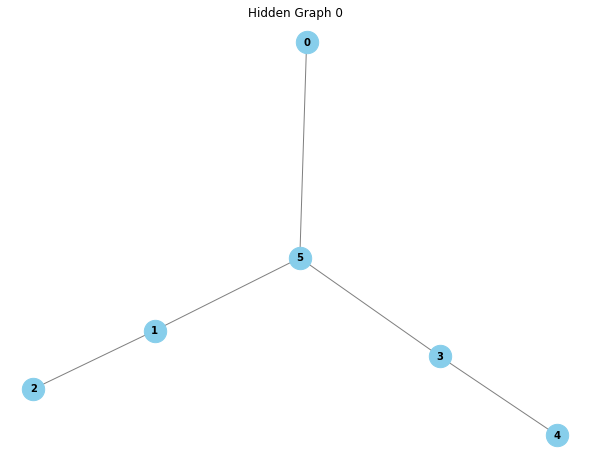

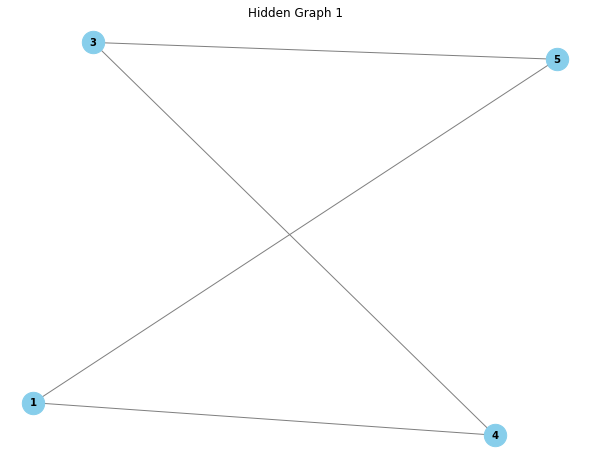

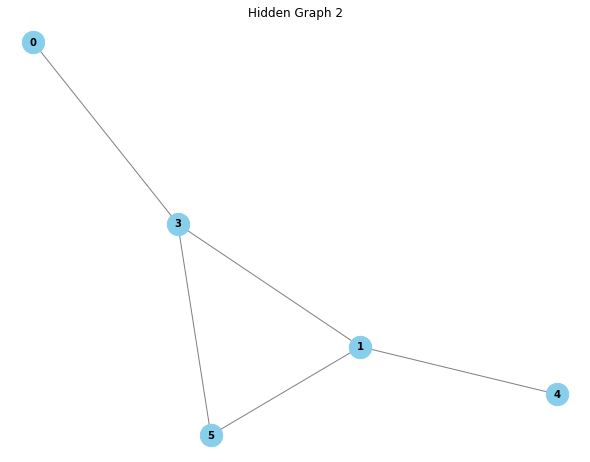

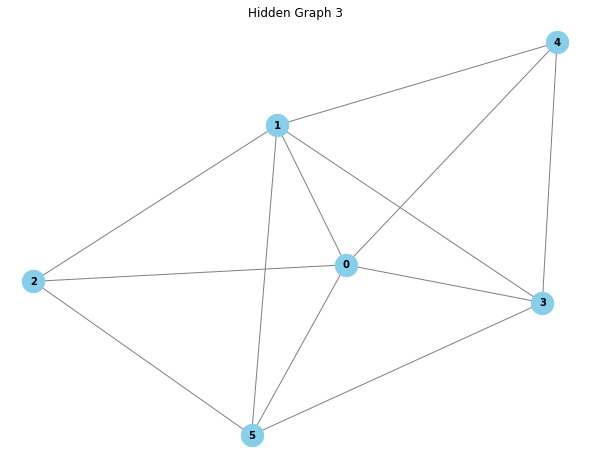

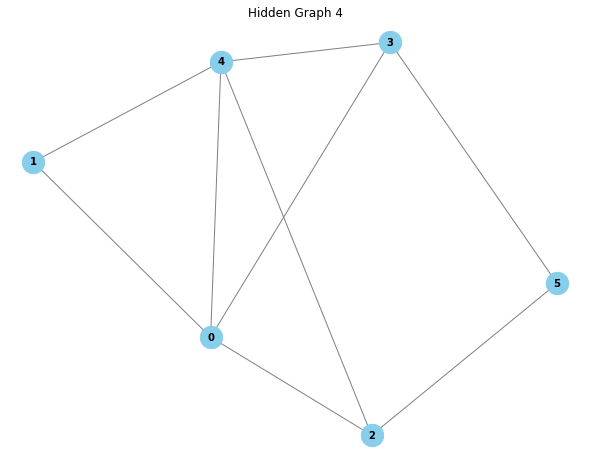

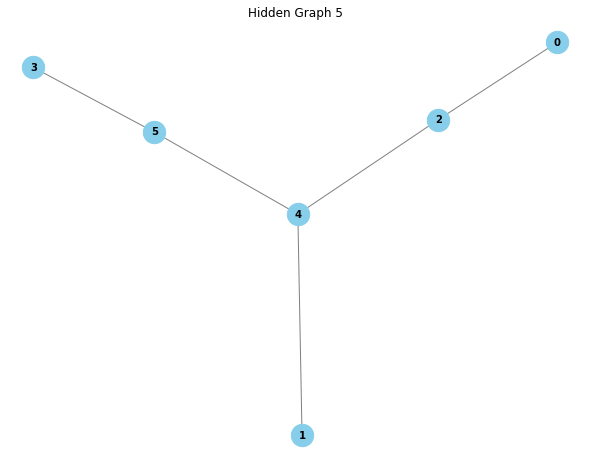

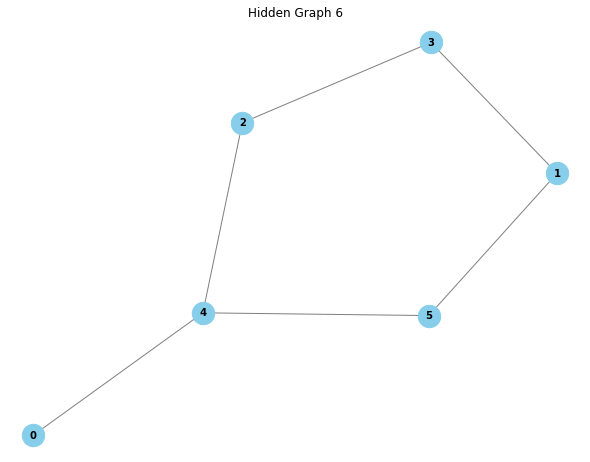

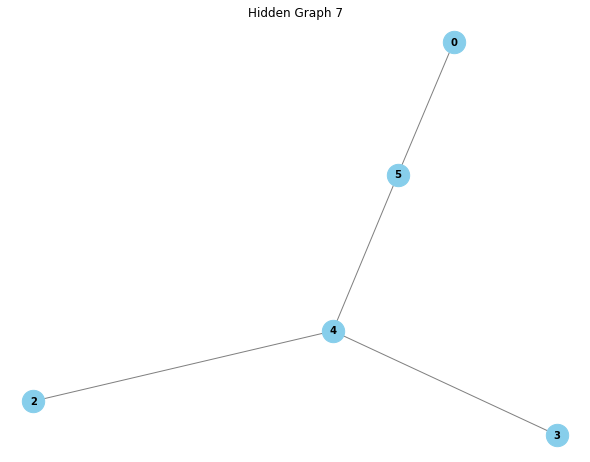

In [530]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming model is defined and adjacency lists are obtained as follows:
adjacency_lists = model.get_hidden_graphs_adjacency_list()

# Draw the adjacency list as a graph using NetworkX and Matplotlib
for i, adj_list in enumerate(adjacency_lists):
    G = nx.Graph()  # Create a new graph
    # Add edges to the graph based on the adjacency list
    for node, neighbors in adj_list.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    # Draw the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)  # Positioning the nodes using the spring layout
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
    plt.title(f"Hidden Graph {i}")
    plt.show()


In [531]:
adjacency_lists = model.get_hidden_graphs_adjacency_list()

graphs = []

# Draw the adjacency list as a graph using NetworkX and Matplotlib
for i, adj_list in enumerate(adjacency_lists):
    G = nx.Graph()  # Create a new graph
    # Add edges to the graph based on the adjacency list
    for node, neighbors in adj_list.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)
    
    for j, graph in enumerate(graphs):
        if nx.is_isomorphic(graph, G):
            print("Graph", i, "is isomorphic to previous graph", j)

    graphs.append(G)
    

Graph 5 is isomorphic to previous graph 0


In [532]:
graph_dist_adj_matrix = np.zeros(shape=(len(graphs),len(graphs)))

for i, graph_1 in enumerate(graphs):
    for j, graph_2 in enumerate(graphs):
        if i == j:
            continue

        graph_edit_distance = nx.graph_edit_distance(graph_1, graph_2)
        print('Edit distance between graph', i, ' and graph', j, ':', graph_edit_distance)
        graph_dist_adj_matrix[i, j] = graph_edit_distance
        
print(graph_dist_adj_matrix)

Edit distance between graph 0  and graph 1 : 5.0
Edit distance between graph 0  and graph 2 : 3.0
Edit distance between graph 0  and graph 3 : 7.0
Edit distance between graph 0  and graph 4 : 4.0
Edit distance between graph 0  and graph 5 : 0.0
Edit distance between graph 0  and graph 6 : 1.0
Edit distance between graph 0  and graph 7 : 2.0
Edit distance between graph 1  and graph 0 : 5.0
Edit distance between graph 1  and graph 2 : 4.0
Edit distance between graph 1  and graph 3 : 10.0
Edit distance between graph 1  and graph 4 : 7.0
Edit distance between graph 1  and graph 5 : 5.0
Edit distance between graph 1  and graph 6 : 6.0
Edit distance between graph 1  and graph 7 : 3.0
Edit distance between graph 2  and graph 0 : 3.0
Edit distance between graph 2  and graph 1 : 4.0
Edit distance between graph 2  and graph 3 : 8.0
Edit distance between graph 2  and graph 4 : 5.0
Edit distance between graph 2  and graph 5 : 3.0
Edit distance between graph 2  and graph 6 : 4.0
Edit distance betwe

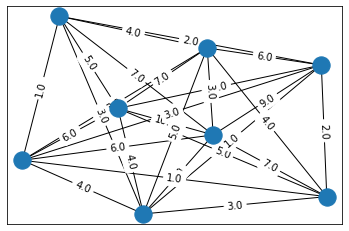

In [533]:
G = nx.from_numpy_array(graph_dist_adj_matrix)

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos)

labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()

In [534]:
import grakel as gkl

adjacency_lists = model.get_hidden_graphs_adjacency_list()

graphs = []

# Create Grakel graphs and random walk kernel
for i, adj_list in enumerate(adjacency_lists):
    G = gkl.Graph(adj_list)
    graphs.append(G)

graph_dist_adj_matrix = np.ones(shape=(len(graphs),len(graphs)))
rw_kernel = gkl.RandomWalk(normalize=True, lamda=0.05)
max_val = 0
min_val = 1

# Calculate graph similarity via random walk
for i, graph_1 in enumerate(graphs):
    for j, graph_2 in enumerate(graphs):
        if i == j:
            continue

        graph_similarity = rw_kernel.fit_transform([graph_1, graph_2])
        print('Similarity between graph', i, ' and graph', j, ':', abs(graph_similarity[0,1]))
        graph_dist_adj_matrix[i, j] = abs(graph_similarity[0,1])
        max_val = max(max_val, abs(graph_similarity[0,1]))
        min_val = min(min_val, abs(graph_similarity[0,1]))

# Scaling factor because most similarity scores are too close to 1
for i in range(len(graphs)):
    for j in range(len(graphs)):
        graph_dist_adj_matrix[i, j] = (graph_dist_adj_matrix[i, j] - min_val) / (max_val - min_val)

print(graph_dist_adj_matrix)

Similarity between graph 0  and graph 1 : 0.9973823603404851
Similarity between graph 0  and graph 2 : 0.9988720822372383
Similarity between graph 0  and graph 3 : 0.5724128556429702
Similarity between graph 0  and graph 4 : 0.9093686784442083
Similarity between graph 0  and graph 5 : 1.0
Similarity between graph 0  and graph 6 : 0.9967885408099503
Similarity between graph 0  and graph 7 : 0.997265074414731
Similarity between graph 1  and graph 0 : 0.9973823603404854
Similarity between graph 1  and graph 2 : 0.9951232894807781
Similarity between graph 1  and graph 3 : 0.5478050436426033
Similarity between graph 1  and graph 4 : 0.8855478497909649
Similarity between graph 1  and graph 5 : 0.9973823603404849
Similarity between graph 1  and graph 6 : 0.9886812665221828
Similarity between graph 1  and graph 7 : 0.9999618481477746
Similarity between graph 2  and graph 0 : 0.9988720822372382
Similarity between graph 2  and graph 1 : 0.9951232894807781
Similarity between graph 2  and graph 3 

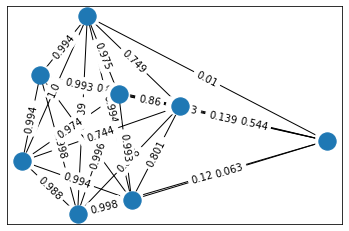

In [535]:
graph_dist_adj_matrix_rounded = np.round(graph_dist_adj_matrix, 3)

G = nx.from_numpy_array(graph_dist_adj_matrix_rounded)

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos)

labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()